In [1]:
import pandas as pd
import numpy as np
import sys,os
import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.patches import Ellipse
import seaborn as sns
%matplotlib inline 
sns.set_style('darkgrid')

# for plot
def plot_point_cov(points, nstd=3, ax=None, **kwargs):
    # 求所有点的均值作为置信圆的圆心
    pos = points.mean(axis=0)
    # 求协方差
    cov = np.cov(points, rowvar=False)
 
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=3, ax=None, **kwargs):
    def eigsorted(cov):
        cov = np.array(cov)
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]
    if ax is None:
        ax = plt.gca()
    vals, vecs = eigsorted(cov)
 
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    ax.add_artist(ellip)
    
    return ellip,pos

/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
#############
# get data
#############
cell = 'MCF7'
fold = 2
data_dir = '/home/jlk/Project/111_Cmap/MOA/analysis/plot_demention/kfold_data'

sig2drugmoa_file = '{}/sig2drugmoa.npz'.format(data_dir)
drug2moa_file = '{}/drug2moa.npz'.format(data_dir)

###############
# train data
#
train_file = '{}/Train_fold_{}_review.h5'.format(data_dir,fold)
test_file = '{}/Test_fold_{}_review.h5'.format(data_dir,fold)

sig2drugmoa_dict = np.load(sig2drugmoa_file)
drug2moa_dict = np.load(drug2moa_file)
train_df = pd.read_hdf(train_file)
test_df = pd.read_hdf(test_file)
print('Train & Test before train',train_df.shape,test_df.shape)

###############
# embedding data
#
train_embedding_file = '/home/jlk/Project/111_Cmap/MOA/src/result_demention_review//train_embedding.h5'.format(data_dir)
test_embedding_file = '/home/jlk/Project/111_Cmap/MOA/src/result_demention_review//test_embedding.h5'.format(data_dir)
train_embedding_df = pd.read_csv(train_embedding_file,index_col=0)
test_embedding_df = pd.read_csv(test_embedding_file,index_col=0)
print('Train & Test Embedding data',train_embedding_df.shape,test_embedding_df.shape)


Train & Test before train (3304, 12328) (2011, 12328)
Train & Test Embedding data (3304, 256) (2011, 256)


In [37]:
#############
# stat moa
#############
moas = ['HDAC-i','HSP-i','MEK/ERK-i','Topo-i','antimetabolite','antimicrotubule',
        'retinoid','proteasome inh.','mTOR-i',
        'PKC-activator','PKC-i',
       'ER agonist','ER antagonist']
moa_dict = {'HDAC-i':1,'HSP-i':2,'MEK/ERK-i':3,
                   'Topo-i':4,'antimetabolite':5,'antimicrotubule':6,
        'retinoid':7,'proteasome inh.':8,'mTOR-i':9,
        'PKC-activator':10,'PKC-i':11,
       'ER agonist':12,'ER antagonist':13}

moas = ['HDAC-i','HSP-i','MEK/ERK-i','Topo-i','antimetabolite','antimicrotubule',
        'retinoid','proteasome inh.','mTOR-i',
        'PKC-activator','PKC-i',
       ]
moa_dict = {'HDAC-i':1,'HSP-i':2,'MEK/ERK-i':3,
                   'Topo-i':4,'antimetabolite':5,'antimicrotubule':6,
        'retinoid':7,'proteasome inh.':8,'mTOR-i':9,
        'PKC-activator':10,'PKC-i':11,
       }

train_sigs = train_df.index
train_moas = [sig2drugmoa_dict[i][1] for i in train_sigs]
moa_counts = Counter(train_moas)
# print('### There are {} moas!'.format(len(moa_counts)))

for moa in moas:
    print(moa,moa_counts[moa])


HDAC-i 238
HSP-i 103
MEK/ERK-i 136
Topo-i 205
antimetabolite 76
antimicrotubule 94
retinoid 82
proteasome inh. 383
mTOR-i 181
PKC-activator 19
PKC-i 16


In [43]:

##################
# before train data
##################
plot_train_index = np.where(np.isin(train_moas,moas),True,False)
plot_train_data = train_df.loc[plot_train_index]

plot_train_x = plot_train_data.values
plot_train_y = [sig2drugmoa_dict[i][1] for i in plot_train_data.index]
plot_train_y = np.array(plot_train_y)

X_tsne_train = TSNE(n_components=2, random_state=1).fit_transform(plot_train_x)
print(X_tsne_train.shape,plot_train_y.shape)

##################
# after train Embedding
##################
train_emb_index_moa = [i.split('_')[0] for i in train_embedding_df.index]
train_moa_index = np.where(np.isin(train_emb_index_moa,moas),True,False)
train_emb_data = train_embedding_df.loc[train_moa_index]
train_emb_moa = [i.split('_')[0] for i in train_emb_data.index] 
train_emb_y = np.array(train_emb_moa)
X_tsne_train_emb = TSNE(n_components=2, random_state=1).fit_transform(train_emb_data)
print(X_tsne_train_emb.shape,train_emb_y.shape)

##################
# test Embedding
##################
drug_moa = {'HDAC-i':'BRD-K02130563',
            'HSP-i':'BRD-K41859756',
            'MEK/ERK-i':'BRD-K49865102',
            'Topo-i':'BRD-A35588707',
            'antimetabolite':'BRD-K15108141',
            'antimicrotubule':'BRD-A28746609',
            'retinoid':'BRD-K25737009',
            'proteasome inh.':'BRD-K60230970',
            'mTOR-i':'BRD-K94294671',
            "PKC-activator":"BRD-K68552125",
             'PKC-i':"BRD-K89687904",
             'ER agonist':"BRD-K97509413",
             'ER antagonist':"BRD-K05151076"
           }

drugs = ['BRD-K02130563',
            'BRD-K41859756',
            'BRD-K49865102',
            'BRD-A35588707',
            'BRD-K15108141',
            'BRD-A28746609',
            'BRD-K25737009',
            'BRD-K60230970',
            'BRD-K94294671',
            "BRD-K68552125",
             "BRD-K89687904",
             "BRD-K97509413",
             "BRD-K05151076"]


test_emb_index_drug = [i.split('_')[1] for i in test_embedding_df.index]
test_drug_index = np.where(np.isin(test_emb_index_drug,drugs),True,False)
test_emb_data = test_embedding_df.loc[test_drug_index]
test_drug = [i.split('_')[1] for i in test_emb_data.index] 

##################
#### Train and Test
##################
plot_train_test_x = pd.concat([train_emb_data,test_emb_data]).values
plot_train_test_y = np.array(train_emb_moa + test_drug)
final_X_tsne = TSNE(n_components=2, random_state=1).fit_transform(plot_train_test_x)
print(final_X_tsne.shape,plot_train_test_y.shape)

/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1594, 2) (1594,)


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1594, 2) (1594,)


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2215, 2) (2215,)


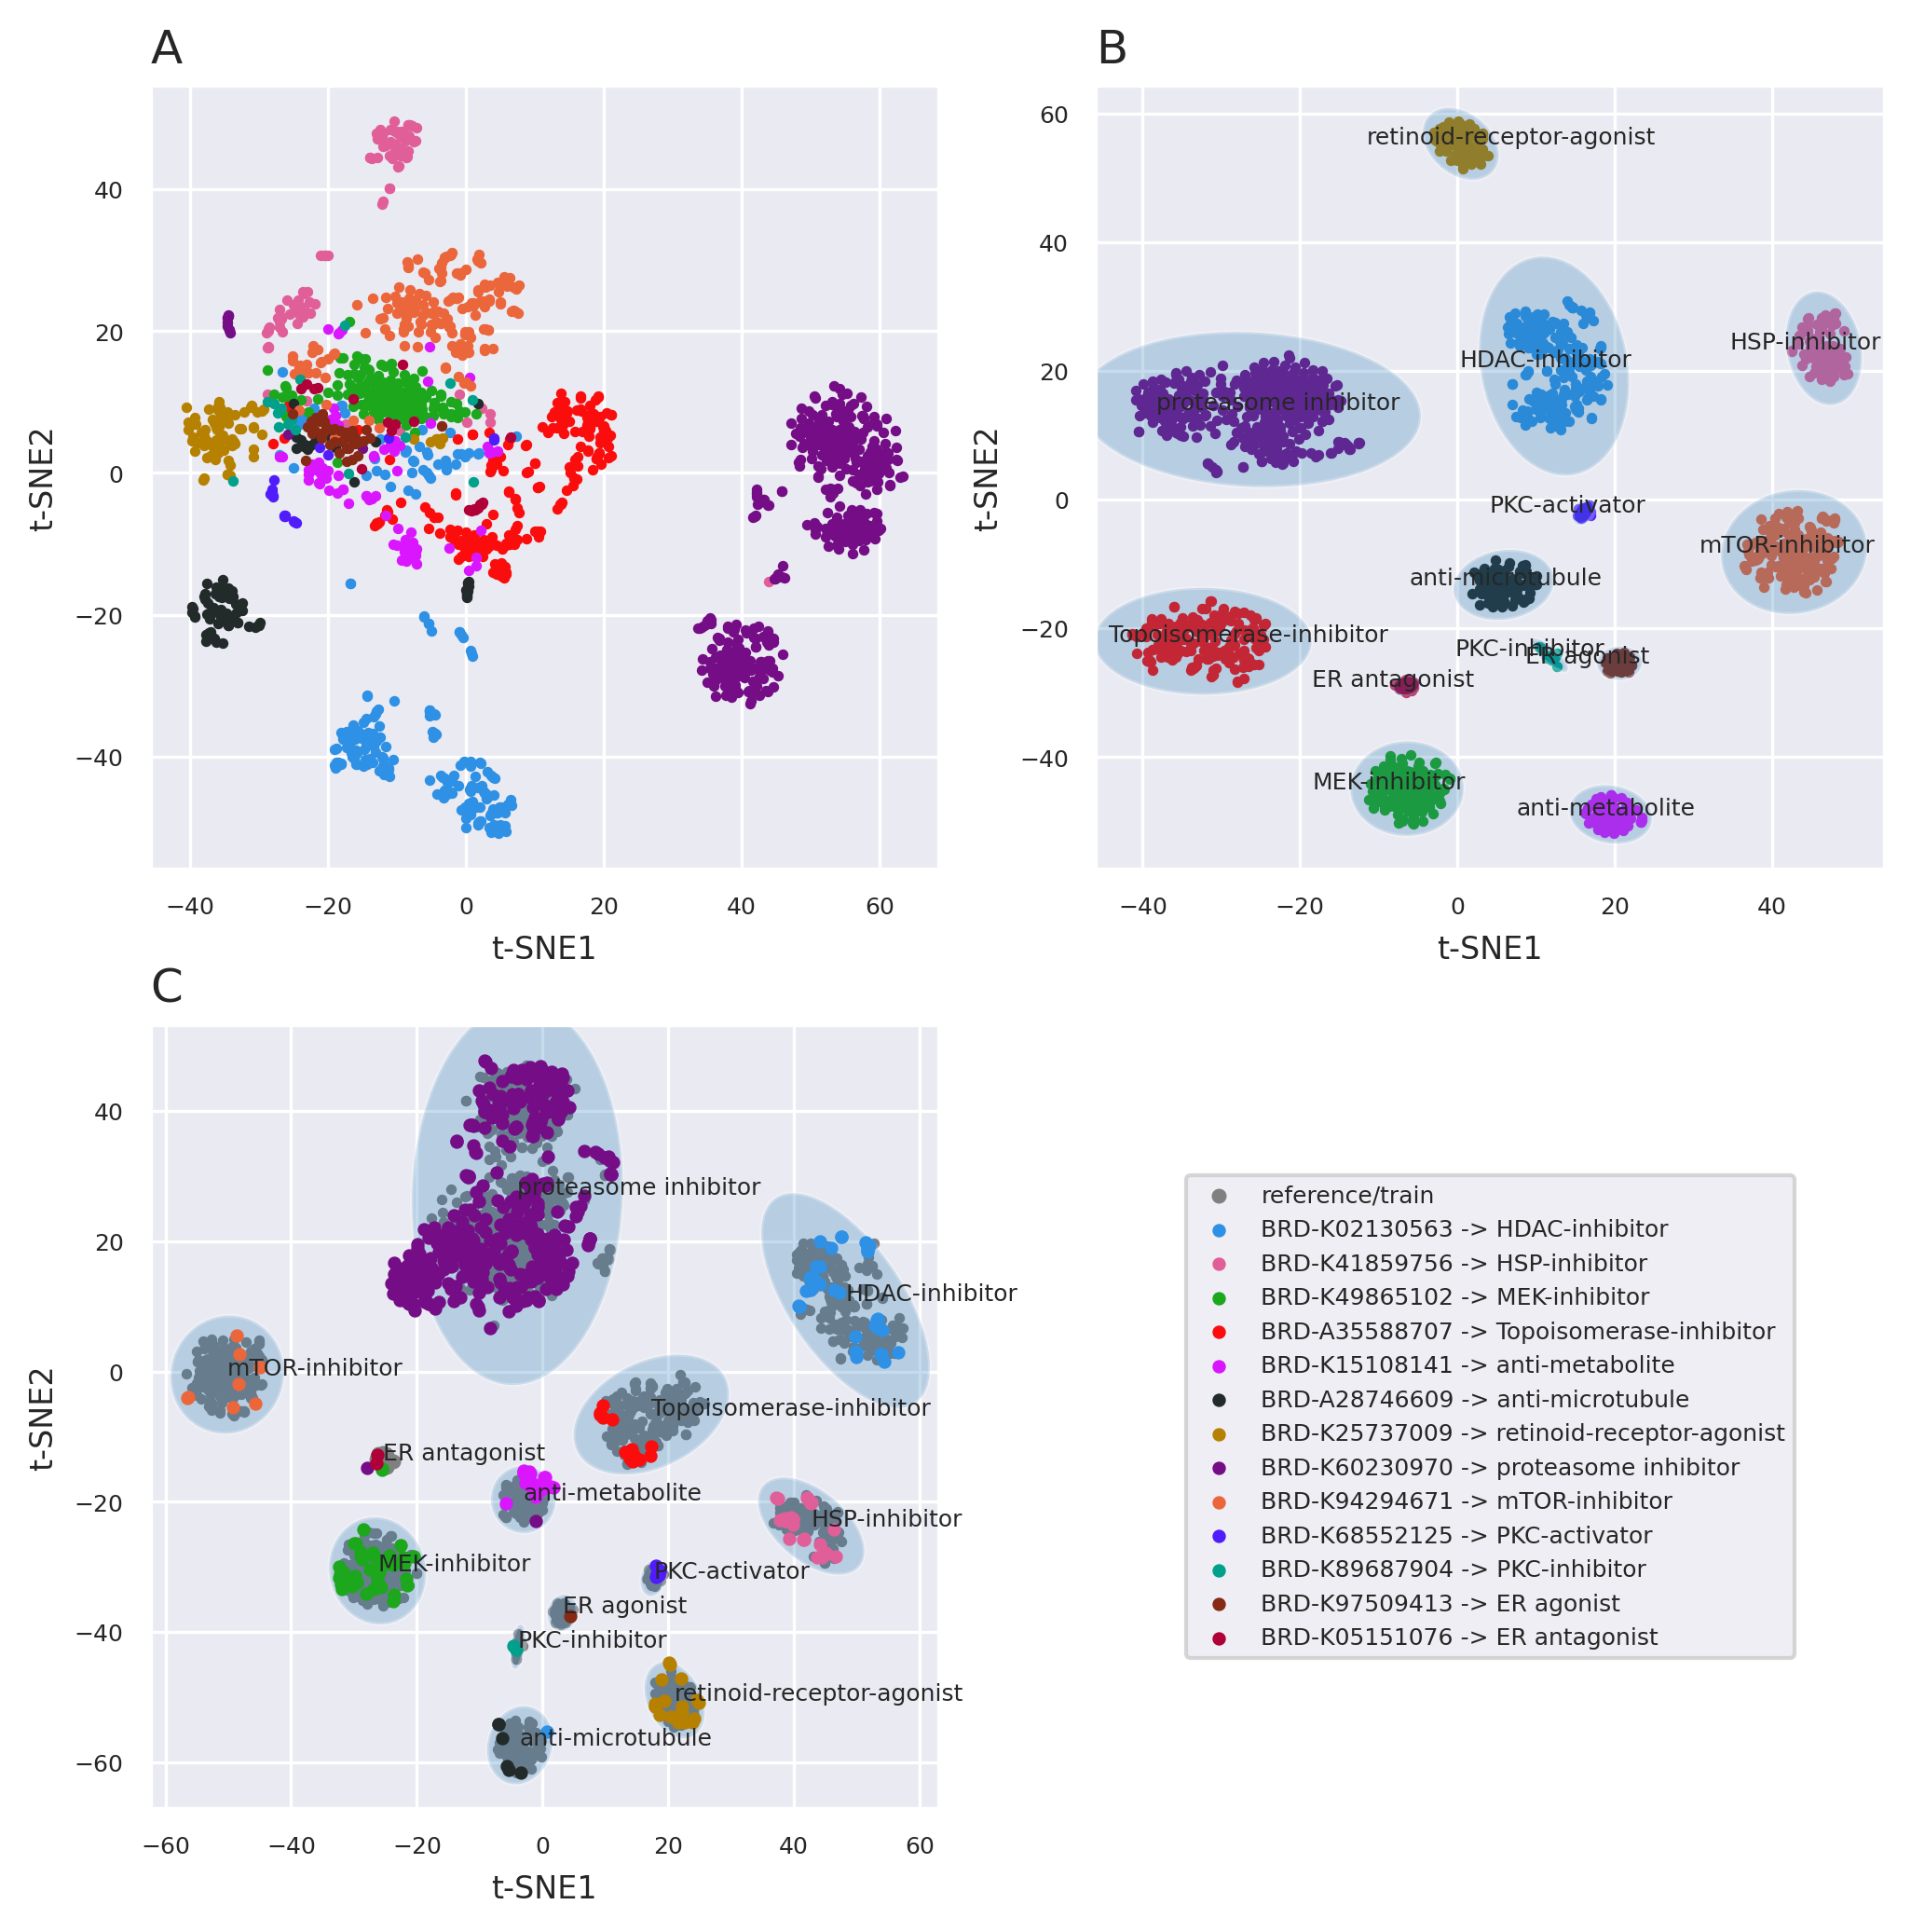

In [52]:
name_dict = {"HDAC-i":"HDAC-inhibitor",
             "HSP-i":"HSP-inhibitor",
             "MEK/ERK-i":"MEK-inhibitor",
             "Topo-i":"Topoisomerase-inhibitor",
             "antimetabolite":"anti-metabolite",
             "antimicrotubule":"anti-microtubule",
             "retinoid":"retinoid-receptor-agonist",
             "proteasome inh.":"proteasome inhibitor",
             "mTOR-i":"mTOR-inhibitor",
            "PKC-activator":"PKC-activator",
             'PKC-i':"PKC-inhibitor",
             'ER agonist':"ER agonist",
             'ER antagonist':"ER antagonist"}
drug_moa_dict = dict([val, key] for key, val in drug_moa.items())
import plotly.express as px
col_map = {}
# col_pal = sns.color_palette("muted")
# col_pal = sns.color_palette("colorblind")
col_pal = px.colors.qualitative.Dark24
col_pal = col_pal[:11] + [col_pal[16]] + [col_pal[23]]

for n in range(len(moas)):
    moa = moas[n]
    col_map[moa] = col_pal[n]

my_dpi=300
plt.figure(figsize=(8,8),dpi=my_dpi)
# fig.tight_layout(h_pad=2)

##################
# before train
plt.subplot(221)
X_tsne = X_tsne_train
y = plot_train_y


for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label = i,color=col_map[i] )
plt.title('A',loc='left')
# plt.xticks([],[])
# plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=8)
plt.ylabel('t-SNE2',fontsize=8)
plt.tick_params(labelsize=6) 

##################
# after train
plt.subplot(222)
X_tsne = X_tsne_train_emb
y = train_emb_y


for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label = i,color=col_map[i])
    _,pos = plot_point_cov(X_tsne[y==i,:], nstd=3, alpha=0.25)
    plt.text(pos[0]-12, pos[1], name_dict[i], fontsize=6)

plt.title('B',loc='left')
# plt.xticks([],[])
# plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=8)
plt.ylabel('t-SNE2',fontsize=8)
plt.tick_params(labelsize=6) 

##################
# train and test drug
plt.subplot(223)
X_tsne = final_X_tsne
y = plot_train_test_y

for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label='_nolegend_',color='grey')
    _,pos = plot_point_cov(X_tsne[y==i,:], nstd=3, alpha=0.25)
    pos0 = pos[0]
    pos1 = pos[1]

#     if i == 'retinoid':
#         pos0 = 15
#         pos1 = -11
#     if i == 'Topo-i':
#         pos0 = 15
#     if i == 'antimicrotubule':
#         pos1 = -24
    plt.text(pos0, pos1, name_dict[i], fontsize=6)

tr_moa_idx = np.where(np.isin(y,moa),True,False)
plt.scatter(X_tsne[tr_moa_idx,0],X_tsne[tr_moa_idx,1],s=8,label = 'reference/train',color='grey')

    
for i in drugs:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=6,label = i+' -> '+name_dict[drug_moa_dict[i]],
                color = col_map[drug_moa_dict[i]])
plt.title('C',loc='left')
# plt.xticks([],[])
# plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=8)
plt.ylabel('t-SNE2',fontsize=8)
plt.tick_params(labelsize=6) 
plt.legend(bbox_to_anchor=(1.3, 0.5), loc='center left',fontsize=6)


plt.show()
# plt.savefig('Figure3.jpg')

In [40]:
moas = ['HDAC-i','HSP-i','MEK/ERK-i','Topo-i','antimetabolite','antimicrotubule',
        'retinoid','proteasome inh.','mTOR-i',
        'PKC-activator','PKC-i',
       'ER agonist','ER antagonist']
moa_dict = {'HDAC-i':1,'HSP-i':2,'MEK/ERK-i':3,
                   'Topo-i':4,'antimetabolite':5,'antimicrotubule':6,
        'retinoid':7,'proteasome inh.':8,'mTOR-i':9,
        'PKC-activator':10,'PKC-i':11,
       'ER agonist':12,'ER antagonist':13}


train_sigs = train_df.index
train_moas = [sig2drugmoa_dict[i][1] for i in train_sigs]
moa_counts = Counter(train_moas)
# print('### There are {} moas!'.format(len(moa_counts)))

for moa in moas:
    print(moa,moa_counts[moa])

HDAC-i 238
HSP-i 103
MEK/ERK-i 136
Topo-i 205
antimetabolite 76
antimicrotubule 94
retinoid 82
proteasome inh. 383
mTOR-i 181
PKC-activator 19
PKC-i 16
ER agonist 40
ER antagonist 21


In [41]:

##################
# before train data
##################
plot_train_index = np.where(np.isin(train_moas,moas),True,False)
plot_train_data = train_df.loc[plot_train_index]

plot_train_x = plot_train_data.values
plot_train_y = [sig2drugmoa_dict[i][1] for i in plot_train_data.index]
plot_train_y = np.array(plot_train_y)

X_tsne_train = TSNE(n_components=2, random_state=1).fit_transform(plot_train_x)
print(X_tsne_train.shape,plot_train_y.shape)

##################
# after train Embedding
##################
train_emb_index_moa = [i.split('_')[0] for i in train_embedding_df.index]
train_moa_index = np.where(np.isin(train_emb_index_moa,moas),True,False)
train_emb_data = train_embedding_df.loc[train_moa_index]
train_emb_moa = [i.split('_')[0] for i in train_emb_data.index] 
train_emb_y = np.array(train_emb_moa)
X_tsne_train_emb = TSNE(n_components=2, random_state=1).fit_transform(train_emb_data)
print(X_tsne_train_emb.shape,train_emb_y.shape)

##################
# test Embedding
##################
drug_moa = {'HDAC-i':'BRD-K02130563',
            'HSP-i':'BRD-K41859756',
            'MEK/ERK-i':'BRD-K49865102',
            'Topo-i':'BRD-A35588707',
            'antimetabolite':'BRD-K15108141',
            'antimicrotubule':'BRD-A28746609',
            'retinoid':'BRD-K25737009',
            'proteasome inh.':'BRD-K60230970',
            'mTOR-i':'BRD-K94294671',
            "PKC-activator":"BRD-K68552125",
             'PKC-i':"BRD-K89687904",
             'ER agonist':"BRD-K97509413",
             'ER antagonist':"BRD-K05151076"
           }

drugs = ['BRD-K02130563',
            'BRD-K41859756',
            'BRD-K49865102',
            'BRD-A35588707',
            'BRD-K15108141',
            'BRD-A28746609',
            'BRD-K25737009',
            'BRD-K60230970',
            'BRD-K94294671',
            "BRD-K68552125",
             "BRD-K89687904",
             "BRD-K97509413",
             "BRD-K05151076"]


test_emb_index_drug = [i.split('_')[1] for i in test_embedding_df.index]
test_drug_index = np.where(np.isin(test_emb_index_drug,drugs),True,False)
test_emb_data = test_embedding_df.loc[test_drug_index]
test_drug = [i.split('_')[1] for i in test_emb_data.index] 

##################
#### Train and Test
##################
plot_train_test_x = pd.concat([train_emb_data,test_emb_data]).values
plot_train_test_y = np.array(train_emb_moa + test_drug)
final_X_tsne = TSNE(n_components=2, random_state=1).fit_transform(plot_train_test_x)
print(final_X_tsne.shape,plot_train_test_y.shape)

/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1594, 2) (1594,)


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1594, 2) (1594,)


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2215, 2) (2215,)


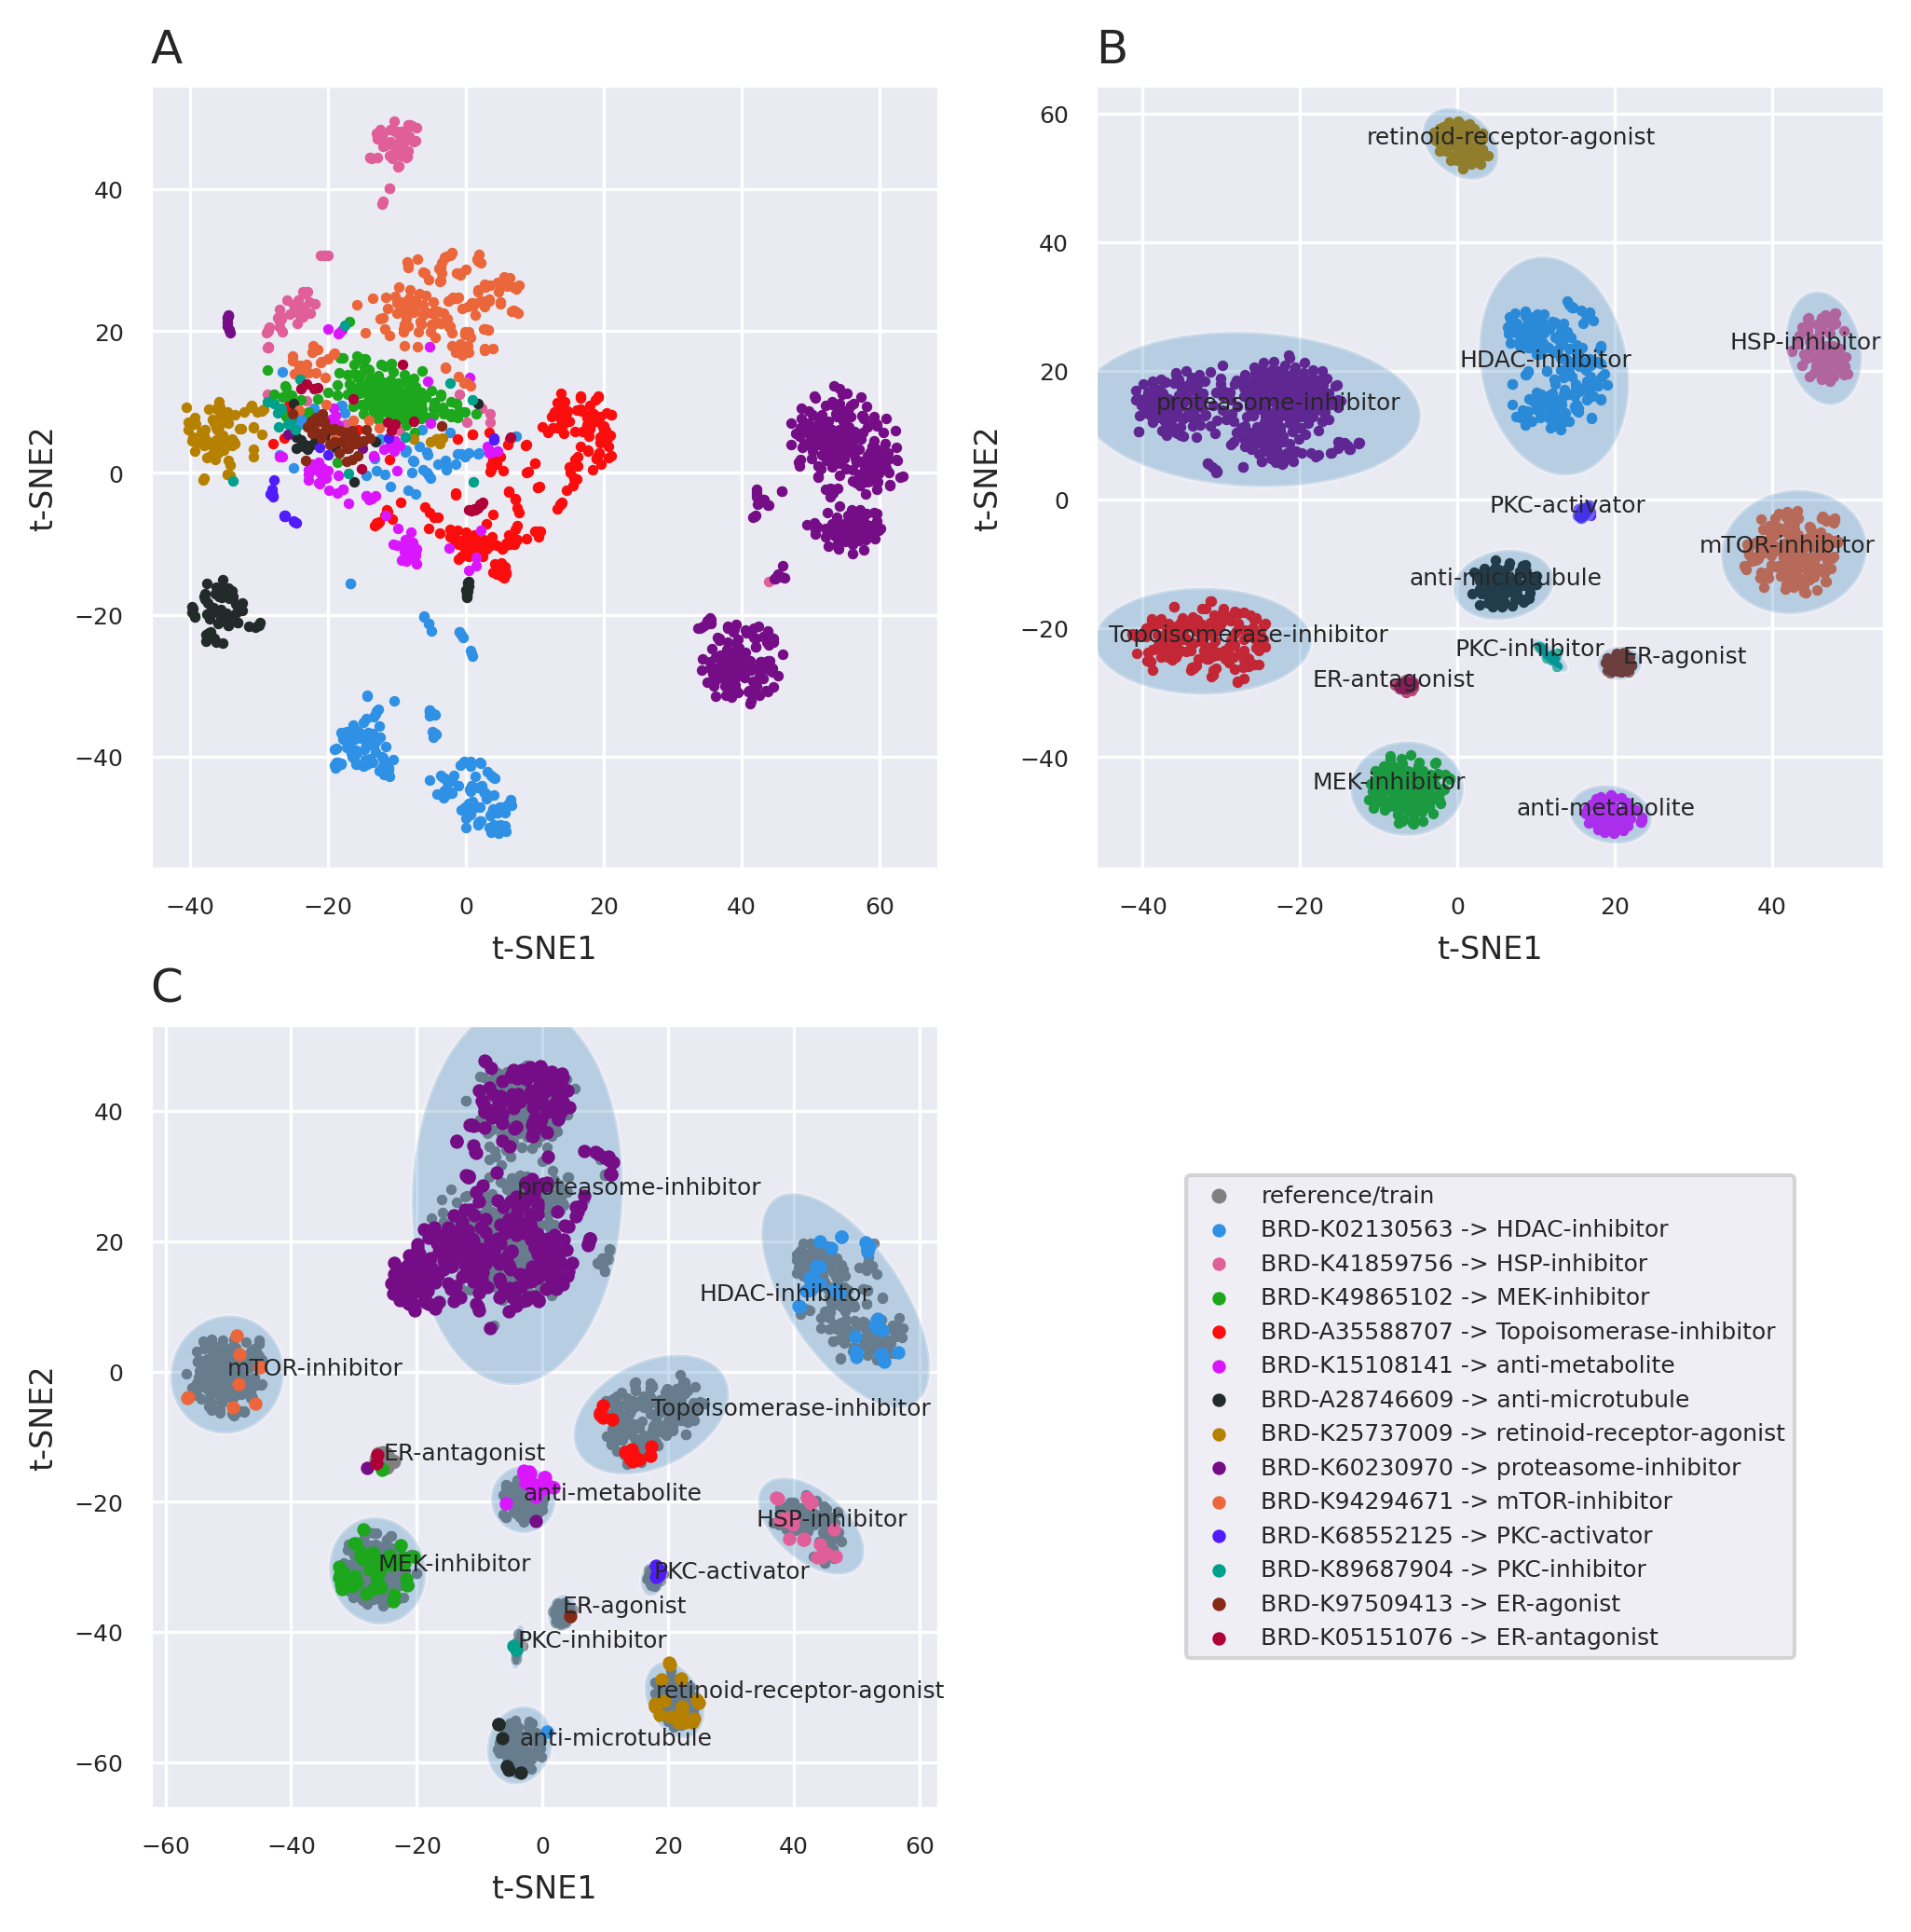

In [54]:
name_dict = {"HDAC-i":"HDAC-inhibitor",
             "HSP-i":"HSP-inhibitor",
             "MEK/ERK-i":"MEK-inhibitor",
             "Topo-i":"Topoisomerase-inhibitor",
             "antimetabolite":"anti-metabolite",
             "antimicrotubule":"anti-microtubule",
             "retinoid":"retinoid-receptor-agonist",
             "proteasome inh.":"proteasome-inhibitor",
             "mTOR-i":"mTOR-inhibitor",
            "PKC-activator":"PKC-activator",
             'PKC-i':"PKC-inhibitor",
             'ER agonist':"ER-agonist",
             'ER antagonist':"ER-antagonist"}
drug_moa_dict = dict([val, key] for key, val in drug_moa.items())
import plotly.express as px
col_map = {}
col_pal = sns.color_palette("muted")
col_pal = sns.color_palette("colorblind")
col_pal = px.colors.qualitative.Dark24
col_pal = col_pal[:11] + [col_pal[16]] + [col_pal[23]]


for n in range(len(moas)):
    moa = moas[n]
    col_map[moa] = col_pal[n]

my_dpi=300
plt.figure(figsize=(8,8),dpi=my_dpi)
# fig.tight_layout(h_pad=2)

##################
# before train
plt.subplot(221)
X_tsne = X_tsne_train
y = plot_train_y


for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label = i,color=col_map[i] )
plt.title('A',loc='left')
# plt.xticks([],[])
# plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=8)
plt.ylabel('t-SNE2',fontsize=8)
plt.tick_params(labelsize=6) 

##################
# after train
plt.subplot(222)
X_tsne = X_tsne_train_emb
y = train_emb_y


for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label = i,color=col_map[i])
    _,pos = plot_point_cov(X_tsne[y==i,:], nstd=3, alpha=0.25)
    pos0 = pos[0]
    pos1 = pos[1]

    if i == 'ER agonist':
        pos0 = 33
    
#     if i == 'Topo-i':
#         pos0 = 15
#     if i == 'antimicrotubule':
#         pos1 = -24
#     plt.text(pos0, pos1, name_dict[i], fontsize=6)
    
    plt.text(pos0-12, pos[1], name_dict[i], fontsize=6)

plt.title('B',loc='left')
# plt.xticks([],[])
# plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=8)
plt.ylabel('t-SNE2',fontsize=8)
plt.tick_params(labelsize=6) 

##################
# train and test drug
plt.subplot(223)
X_tsne = final_X_tsne
y = plot_train_test_y

for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label='_nolegend_',color='grey')
    _,pos = plot_point_cov(X_tsne[y==i,:], nstd=3, alpha=0.25)
    pos0 = pos[0]
    pos1 = pos[1]

    if i == 'retinoid':
        pos0 = 18
        pos1 = -50
    if i == 'HDAC-i':
        pos0 = 25
    if i == 'HSP-i':
        pos0 = 34
    plt.text(pos0, pos1, name_dict[i], fontsize=6)

tr_moa_idx = np.where(np.isin(y,moa),True,False)
plt.scatter(X_tsne[tr_moa_idx,0],X_tsne[tr_moa_idx,1],s=8,label = 'reference/train',color='grey')

    
for i in drugs:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=6,label = i+' -> '+name_dict[drug_moa_dict[i]],
                color = col_map[drug_moa_dict[i]])
plt.title('C',loc='left')
# plt.xticks([],[])
# plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=8)
plt.ylabel('t-SNE2',fontsize=8)
plt.tick_params(labelsize=6) 
plt.legend(bbox_to_anchor=(1.3, 0.5), loc='center left',fontsize=6)


# plt.show()
plt.savefig('Figure3.jpg')

In [26]:
col_pal = sns.color_palette("muted")
col_pal = sns.color_palette("colorblind")
col_pal = px.colors.qualitative.Dark24
print(col_pal)



['#2E91E5', '#E15F99', '#1CA71C', '#FB0D0D', '#DA16FF', '#222A2A', '#B68100', '#750D86', '#EB663B', '#511CFB', '#00A08B', '#FB00D1', '#FC0080', '#B2828D', '#6C7C32', '#778AAE', '#862A16', '#A777F1', '#620042', '#1616A7', '#DA60CA', '#6C4516', '#0D2A63', '#AF0038']


[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039), (0.9333333333333333, 0.5215686274509804, 0.2901960784313726), (0.41568627450980394, 0.8, 0.39215686274509803), (0.8392156862745098, 0.37254901960784315, 0.37254901960784315), (0.5843137254901961, 0.4235294117647059, 0.7058823529411765), (0.5490196078431373, 0.3803921568627451, 0.23529411764705882), (0.8627450980392157, 0.49411764705882355, 0.7529411764705882), (0.4745098039215686, 0.4745098039215686, 0.4745098039215686), (0.8352941176470589, 0.7333333333333333, 0.403921568627451), (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]


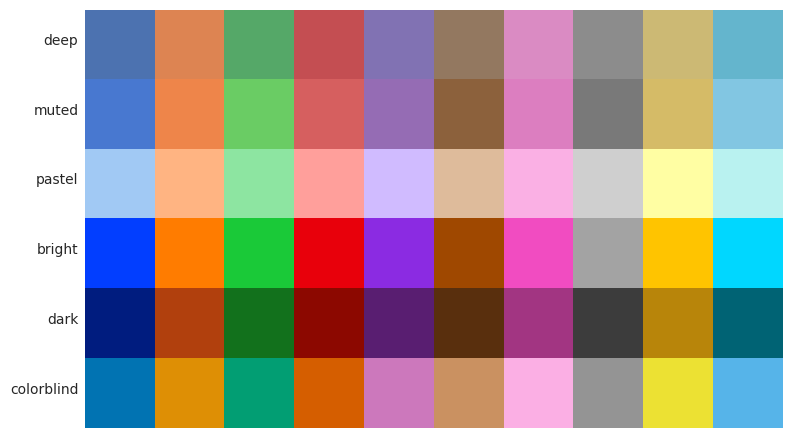

In [21]:
import seaborn as sns
pallettes = ["deep", "muted", "pastel", "bright", "dark", "colorblind"]
data = np.array([sns.color_palette(pat) for pat in pallettes])
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(111)
# print(data)
ax.imshow(data)
for i, pat in enumerate(pallettes):
    ax.text(-0.6, i, pat, ha="right")
plt.axis("off");

col_map = {}
print(sns.color_palette("muted"))